[Car-Dataset](https://www.kaggle.com/datasets/sshikamaru/car-object-detection?fbclid=IwAR2upw-XG64rvz0rPASIOTRmVmzg31rKsfW7afszmem17BIXRXCm5u3TShA)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall --yes opencv-contrib-python opencv-python
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 66.7 MB 23 kB/s 


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print('Image(Train):',len(os.listdir('/content/drive/MyDrive/Colab Notebooks/car-detection/data/training_images')))
print('Image(Test):',len(os.listdir('/content/drive/MyDrive/Colab Notebooks/car-detection/data/testing_images')))

Image(Train): 1001
Image(Test): 177


In [ ]:
Data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/car-detection/data/train_solution_bounding_boxes (1).csv')
Data.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [ ]:
print('Train data localization:',len(Data))

Train data localization: 559


Photo shape: (380, 676, 3)
Name,xmin,ymin,xmax,ymax: ['vid_4_1000.jpg' 281.2590449 187.0350708 327.7279305 223.225547]


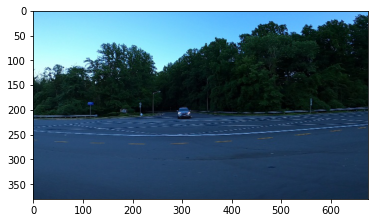

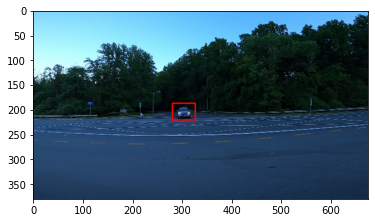

In [ ]:
for i in Data.values:
  photo=plt.imread(f'/content/drive/MyDrive/Colab Notebooks/car-detection/data/training_images/{i[0]}')
  plt.imshow(photo)
  print('Photo shape:',photo.shape)
  print('Name,xmin,ymin,xmax,ymax:',i)
  pt1=(int(i[1]),int(i[2]))
  pt2=(int(i[3]),int(i[4]))
  color=(255, 0, 0)
  thickness = 2
  cv2.rectangle(photo,pt1,pt2, color, thickness)
  plt.figure()
  plt.imshow(photo)
  break

# Annotations (Check)

(380, 676, 3)
(380, 676, 3)
(380, 676, 3)


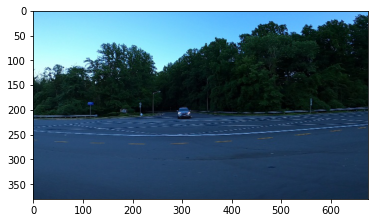

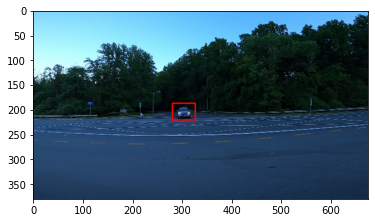

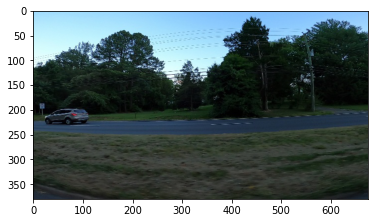

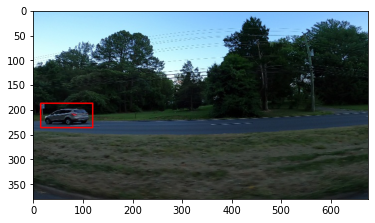

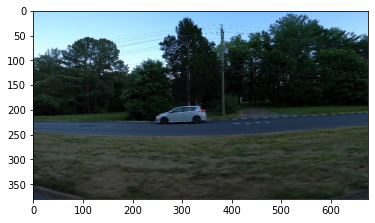

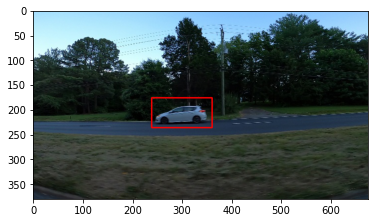

In [ ]:
for a,i in enumerate(Data.values):
  img=plt.imread('/content/drive/MyDrive/Colab Notebooks/car-detection/data/training_images/'+i[0])
  print(img.shape)
  plt.figure()
  plt.imshow(img)
  xmin=int(i[1])
  ymin=int(i[2])
  xmax=int(i[3])
  ymax=int(i[4])
  cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(255, 0, 0),2)
  plt.figure()
  plt.imshow(img)
  if a ==2:
    break

# Selective Search

In [ ]:
cv2.setUseOptimized(True) # Optimeze
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # Selective search object

Shape: (224, 224, 3)
possible bounding boxes: 297


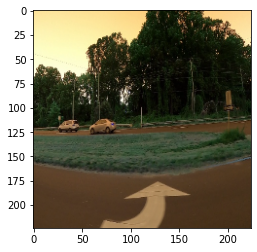

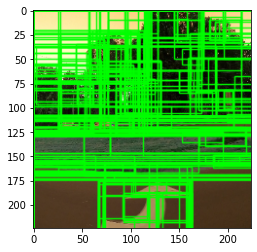

In [ ]:
im = cv2.imread('/content/drive/MyDrive/Colab Notebooks/car-detection/data/training_images/vid_4_9320.jpg')
im=cv2.resize(im,(224,224))
plt.figure()
plt.imshow(im)
ss.setBaseImage(im) 
ss.switchToSelectiveSearchFast() # Selective Search 
rects = ss.process()
print('Shape:',im.shape)
print('possible bounding boxes:',len(rects))

for rect in rects:
  x, y, w, h = rect
  imOut=cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imOut);

# Selective serach crop the image iou>0.5

**Selective search**

In [ ]:
#Iou and selective search 
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def get_iou(bb1, bb2):

    assert bb1['x1'] < bb1['x2'] #bb1
    assert bb1['y1'] < bb1['y2']

    assert bb2['x1'] < bb2['x2'] #bb2
    assert bb2['y1'] < bb2['y2'];

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
      return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
image_liste=[]
k=0
l=0
z=0 #Loading
for a in pd.read_csv('/content/drive/MyDrive/Colab Notebooks/car-detection/data/train_solution_bounding_boxes (1).csv').values:
  Name,xmin,ymin,xmax,ymax=a
  bb1={ #creating bounding boxxes
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
  try:
    img=cv2.imread('/content/drive/MyDrive/Colab Notebooks/car-detection/data/training_images/'+Name)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    for i in rects:
      x, y, w, h = i # Selective bounding boxxes
      bb2={'x1':x, 
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }
      img1=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']] # Crop img
      img1_shape=cv2.resize(img1,(224,224))
      if k<l:
            if 0.5<get_iou(bb1,bb2):  
              image_liste.append([img1_shape,1])
              k+=1
      else:
        if 0.5<get_iou(bb1,bb2):  
          image_liste.append([img1_shape,1])
          k+=1
        else:
          image_liste.append([img1_shape,0])
          l+=1
  except Exception as e:
    print('Error',e)
  z+=1
  print(Name,z,len(rects))

vid_4_1000.jpg 1 1101
vid_4_10000.jpg 2 1456
vid_4_10040.jpg 3 1403
vid_4_10020.jpg 4 1489
vid_4_10060.jpg 5 1315
vid_4_10100.jpg 6 1537
vid_4_10120.jpg 7 1430
vid_4_10140.jpg 8 1544
vid_4_1020.jpg 9 1117
vid_4_1040.jpg 10 1146
vid_4_10480.jpg 11 1663
vid_4_10500.jpg 12 1815
vid_4_10520.jpg 13 1725
vid_4_1060.jpg 14 1251
vid_4_10960.jpg 15 1894
vid_4_10980.jpg 16 1676
vid_4_11000.jpg 17 1754
vid_4_11020.jpg 18 1553
vid_4_11240.jpg 19 1779
vid_4_11260.jpg 20 1863
vid_4_11280.jpg 21 1846
vid_4_11380.jpg 22 1884
vid_4_11400.jpg 23 1929
vid_4_11420.jpg 24 1925
vid_4_11440.jpg 25 1880
vid_4_11900.jpg 26 1801
vid_4_11880.jpg 27 1824
vid_4_11920.jpg 28 1857
vid_4_11940.jpg 29 1947
vid_4_11960.jpg 30 1932
vid_4_11980.jpg 31 1970
vid_4_12000.jpg 32 1901
vid_4_12040.jpg 33 1979
vid_4_12100.jpg 34 1971
vid_4_12060.jpg 35 1879
vid_4_12080.jpg 36 1870
vid_4_12120.jpg 37 1821
vid_4_12140.jpg 38 1632
vid_4_12140.jpg 39 1632
vid_4_12160.jpg 40 1682
vid_4_12160.jpg 41 1682
vid_4_12160.jpg 42 1682
vid_4

In [ ]:
data=[]
data_label=[]
for features,label in image_liste:
  data.append(features)
  data_label.append(label)

print('Numbers of Features:',len(data),'\nNumbers of Labels:',len(data_label))

Numbers of Features: 10581 
Numbers of Labels: 10581


Class: 1
Image Size: (224, 224, 3)


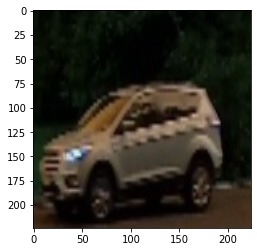

In [ ]:
i=random.randint(1,10583)
print('Class:',data_label[i])
print('Image Size:',data[i].shape)
plt.imshow(data[i]);

In [ ]:
data=np.asarray(data)
data_label=np.asarray(data_label) 
print('No car image:',len(data_label[data_label==0]),'One car image:',len(data_label[data_label==1]))
print(data.shape)
print(data_label.shape)

No car image: 5291 One car image: 5290
(10581, 224, 224, 3)
(10581,)
